#### import pandas as pd
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import seaborn as sbn


%matplotlib inline

In [4]:
SMdata=pd.read_csv("Data/Socio-mobility-Copy1.csv",index_col=0)

In [5]:
SMdata.head()

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,...,unemployment_rate,percent_uninsured,mean_price_per_sqft,median_price_per_sqft,citibike_spatial,mobile-device_spatial,sr311_spatial,subway_spatial,taxi_spatial,twitter_spatial
tz,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,383102,0,0.0,95418,1546
2,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0,6348,0,0.0,73,44
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,...,10.045116,8.402712,318.691787,315.104167,0,109300,700,225527.5,31960,480
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,...,9.031957,8.955406,NaN,NaN,31545,179644,399,0.0,178515,85
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,...,5.503406,3.673850,289.552591,276.162791,0,56271,490,0.0,3667,40


In [6]:
SMdata.fillna(0,inplace=True); SMdata.head()

,population,male,female,age_under_14,age_15_29,age_30_54,age_55_over,white,black,asian,...,unemployment_rate,percent_uninsured,mean_price_per_sqft,median_price_per_sqft,citibike_spatial,mobile-device_spatial,sr311_spatial,subway_spatial,taxi_spatial,twitter_spatial
tz,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,383102,0,0.0,95418,1546
2,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0,6348,0,0.0,73,44
3,32450.0,15235.0,17215.0,16.351856,20.033410,34.419509,29.195225,31.959938,35.189522,8.311248,...,10.045116,8.402712,318.691787,315.104167,0,109300,700,225527.5,31960,480
4,27571.0,12546.0,15025.0,12.032675,24.910563,38.007785,25.048977,40.201661,13.778971,14.185195,...,9.031957,8.955406,0.000000,0.000000,31545,179644,399,0.0,178515,85
5,26482.0,13082.0,13400.0,18.400166,17.316894,36.133183,28.149757,89.064270,1.771014,6.532739,...,5.503406,3.673850,289.552591,276.162791,0,56271,490,0.0,3667,40


In [13]:
import shapefile as shp
from shapely.geometry.polygon import Polygon
from descartes import PolygonPatch

nyshp = shp.Reader('Data/taxi_zones.shp')
nyshp_records=nyshp.records()
nyshp_shape=nyshp.shapeRecords()


In [14]:
SMdata.columns

Index([u'population', u'male', u'female', u'age_under_14', u'age_15_29',
       u'age_30_54', u'age_55_over', u'white', u'black', u'asian', u'others',
       u'two_or_more', u'less_high_school', u'high_school', u'college',
       u'bachelor', u'graduate', u'median_income_households',
       u'median_income_families', u'median_income_nonfamily',
       u'mean_income_households', u'mean_income_families',
       u'mean_income_nonfamily', u'percent_below_poverty',
       u'unemployment_rate', u'percent_uninsured', u'mean_price_per_sqft',
       u'median_price_per_sqft', u'citibike_spatial', u'mobile-device_spatial',
       u'sr311_spatial', u'subway_spatial', u'taxi_spatial',
       u'twitter_spatial'],
      dtype='object')

In [31]:
import math
def plot_on_map(shp,df,column,areaNorm=False,logScale=False):
    #take shapefile as shp, dataframe as df, a column to visualize and two flags on whether to normalize by area and to take log scale
    
    #shortcuts for accessing records and points of the shapes
    shp_records=shp.records()
    shp_shape=shp.shapeRecords()
    
    x = {} #dictionary for values to visualize for each key - create it below
    
    for tz in df.index:
        key=tz
        x[key]=df[column][tz]

    y = {} #normalized version of the values now assigned to each shape already
    for s in range(0,len(shp_records)):
        z=int(shp_records[s][0])
        if z in x.keys(): 
            x_ = x[z]
            if areaNorm:
                x_ = x_ / float(shp_records[s][2])
            if logScale:
                x_ = math.log( x_+(x_==0))
            y[z] = x_    
                
    #min-max values            
    maxY=max(y.values())
    minY=min(y.values())
    
    if logScale: #if log-scale limit the scale to the values no lower than exp(-3)~0.04 of the max
        minY=maxY-3
    
    #prepare colormap
    cbins=20; #number of colorscale bins
    cmap = plt.cm.cool(np.linspace(0,1,cbins+1))
    #plot new figure
    fig = plt.figure(figsize = (12,15)) 
    ax = fig.gca()
    
    #visualize each shape with the color depending on the value 
    for s in range(0,len(shp_records)): #for all shapes
        z=int(shp_records[s][0]) #take the shape id
        if z in y.keys(): #if it has a corresponding value       
            k=int(cbins*(y[z]-minY)/(maxY-minY)) #pick up a color based on a value
            if k<0: #truncate negatives (can occur in log-scale due to sclae limitation)
                k=0
            c=cmap[k][0:3] #get the RGB color  
            #get x,y of the shape
            shape=shp_shape[s]
            x_ = [i[0] for i in shape.shape.points[:]]
            y_ = [i[1] for i in shape.shape.points[:]]
            #plot a polygon of that shape
            poly=Polygon(zip(x_,y_))
            ax.add_patch(PolygonPatch(poly, fc=c, ec='k', alpha=0.5, zorder=2))

    ax.axis('scaled')
    
    plt.title("median_income_families in New York City",size=20)
   

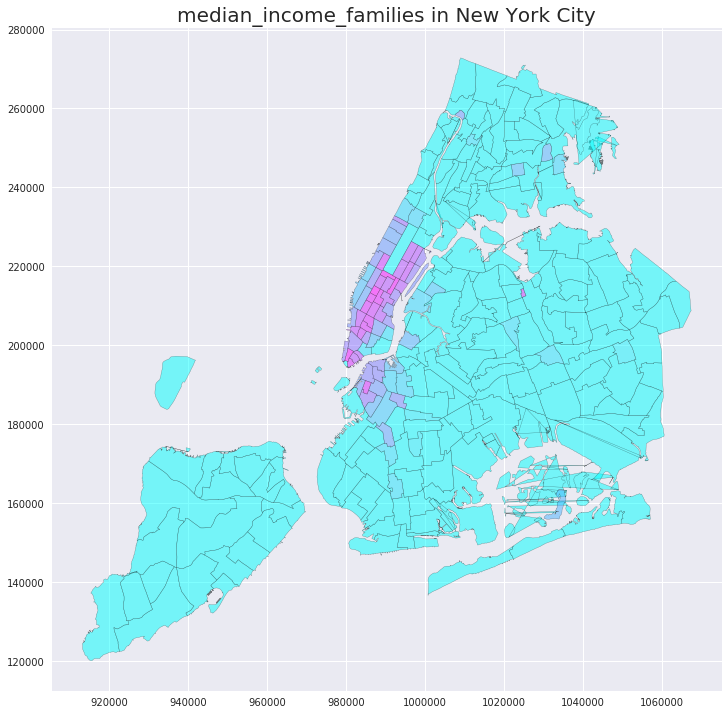

In [32]:
plot_on_map(nyshp,SMdata,'median_income_families',areaNorm=True,logScale=True)

Figure one: This figure representes the spatial data for the location of median income New York household. Acoording to the map, most of the median income families locates in manhattan, especially in lower east side and midtown, as well as downtown Brooklyn. The darker the color represent the higher the families density per each PUMA area. 